In [2]:
import pandas as pd
df = pd.read_excel('cleaned_data.xlsx')
df['Half_year'] = [x[:4]+'-1' if int(x[5:7]) < 7 else x[:4]+'-2' for x in df['Date']]
df.head(1)

,DOI,Base_URL,Download,Status,Url,Title,Year,Date,Type,Cited,Cites,file_name,file_size,last_modified,Abstract,clean_non_english,clean_start_w_abs,clean_start_w_ads,Half_year
0,NaN,https://www.sci-hub.ren/10.1201/9780429065507-1,NaN,无法访问目标网站。,https://openalex.org/W2476002196,Computational Materials Design in Semiconducto...,2019,2019-05-08,book-chapter,0,https://api.openalex.org/works?filter=cites:W2...,NaN,NaN,NaN,This chapter discusses a possible new methodol...,This chapter discusses a possible new methodol...,This chapter discusses a possible new methodol...,This chapter discusses a possible new methodol...,2019-1


In [3]:
df_count = df.groupby('Half_year')['Abstract'].count()
df_count

Half_year
2018-1    1926
2018-2    1526
2019-1    2059
2019-2    1645
2020-1    1974
2020-2    1640
Name: Abstract, dtype: int64

In [5]:
with open(f'vector_terms/60_vector_terms.txt','r',encoding='utf-8') as file:
    your_vocab_list = [term[:-1].lower() for term in file.readlines()]
len(your_vocab_list)

37266

In [97]:
from tqdm import tqdm
occurence_frequency = pd.DataFrame(columns=['term','2018-1','2018-2','2019-1','2019-2','2020-1','2020-2'])
document_frequency = pd.DataFrame(columns=['term','2018-1','2018-2','2019-1','2019-2','2020-1','2020-2'])
for n in tqdm(range(len(your_vocab_list))):
    vocab = your_vocab_list[n]
    lst1 = [vocab]
    lst2 = [vocab]
    for idx, group in df.groupby('Half_year')['Abstract']:
        occ = 0
        doc = 0
        for abstract in group:
            c = abstract.count(vocab)
            if c != 0:
                occ += c
                doc += 1
        lst1.append(occ)
        lst2.append(doc)
    occurence_frequency.loc[len(occurence_frequency),:] = lst1
    document_frequency.loc[len(document_frequency),:] = lst2
print(len(occurence_frequency), len(document_frequency))           

100%|██████████| 37266/37266 [09:28<00:00, 65.50it/s]

37266 37266


In [98]:
import ast
topic_results = pd.read_excel(f'topic_results/60_topic_results.xlsx')
terms = set()
for n in [6,11,12,23,46,48,53]:
    for term in ast.literal_eval(topic_results.Representation[n]):
        terms.add(term)
len(terms)

1141

In [99]:
oc = pd.DataFrame(columns=occurence_frequency.columns)
dc = pd.DataFrame(columns=document_frequency.columns)
for i in range(len(occurence_frequency)):
    if occurence_frequency.term[i] in terms:
        oc.loc[len(oc),:] = occurence_frequency.loc[i,:]
        dc.loc[len(dc),:] = document_frequency.loc[i,:]
print(len(oc),len(dc))

1141 1141


In [213]:
#oc.to_excel('of.xlsx',index=False)
#dc.to_excel('df.xlsx',index=False)
oc = pd.read_excel('of.xlsx')
dc = pd.read_excel('df.xlsx')

In [214]:
dov = oc.copy()
dod = dc.copy()
for idx, period in enumerate(df_count.index):
    dov[period] = (dov[period] / df_count[period]) * (1 - (0.05 * (len(df_count) - idx)))
    dod[period] = (dod[period] / df_count[period]) * (1 - (0.05 * (len(df_count) - idx)))

In [215]:
rate_dov = []
rate_dod = []
for i in range(len(dov)):
    first_dov = dov['2018-1'][i]
    first_dod = dod['2018-1'][i]
    last_dov = dov['2020-2'][i]
    last_dod = dod['2020-2'][i]
    if first_dov != 0:
        rate_dov.append(((last_dov / first_dov) ** (1 / 5)) - 1)
    else:
        rate_dov.append(0)
    if first_dod != 0:
        rate_dod.append(((last_dod / first_dod) ** (1 / 5)) - 1)
    else:
        rate_dod.append(0)
dov['rate'] = rate_dov
dod['rate'] = rate_dod

In [109]:
dov.head(5)

,term,2018-1,2018-2,2019-1,2019-2,2020-1,2020-2,rate
0,10,0.215888,0.280144,0.255658,0.297112,0.308663,0.384055,0.122104
1,100,0.051246,0.077654,0.057115,0.070790,0.067477,0.083415,0.102342
2,100083,0.000000,0.005898,0.000000,0.000000,0.000000,0.000000,0.000000
3,1016,0.000000,0.001474,0.000389,0.001550,0.004559,0.001159,0.000000
4,11,0.053063,0.080603,0.059835,0.070274,0.080699,0.092104,0.116597


In [216]:
oc.set_index('term', inplace=True)
dc.set_index('term', inplace=True)
oc['average'] = oc.mean(axis=1)
dc['average'] = dc.mean(axis=1)
oc.reset_index(inplace=True)
dc.reset_index(inplace=True)
oc.head(5)

,term,2018-1,2018-2,2019-1,2019-2,2020-1,2020-2,average
0,10,594,570,658,575,677,663,622.833333
1,100,141,158,147,137,148,144,145.833333
2,100083,0,12,0,0,0,0,2.000000
3,1016,0,3,1,3,10,2,3.166667
4,11,146,164,154,136,177,159,156.000000


In [217]:
idx = int(len(oc) * 0.3)
print(idx)

of_x = oc['average'].sort_values(ascending=True).reset_index(drop=True)[idx]
df_x = dc['average'].sort_values(ascending=True).reset_index(drop=True)[idx]
print(of_x, df_x)

of_y = dov.rate.sort_values(ascending=False).reset_index(drop=True)[idx]
df_y = dod.rate.sort_values(ascending=False).reset_index(drop=True)[idx]
print(of_y, df_y)

342
13.666666666666666 9.666666666666666
0.12420804570079613 0.10951599668426448


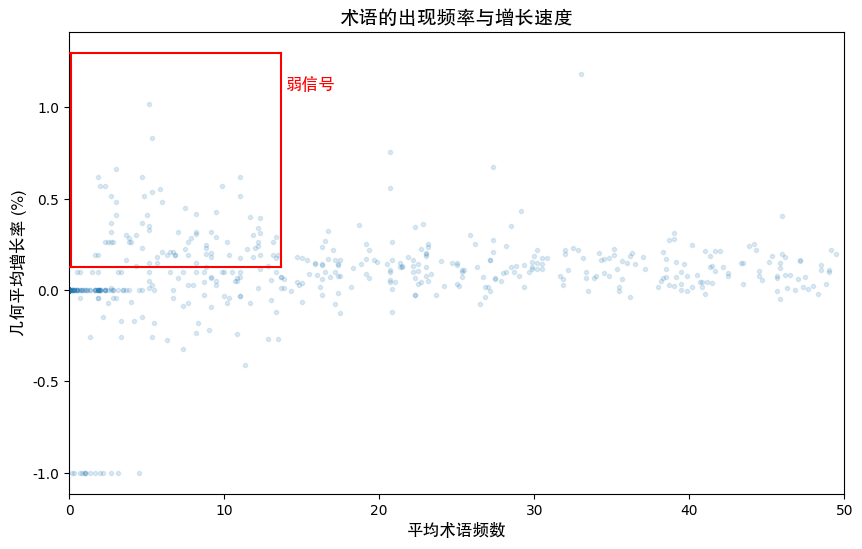

In [218]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties

# 加载字体
font_prop = FontProperties(fname='font.ttf')
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10,6))
plt.scatter(oc.average, dov.rate, marker='.', alpha=0.15)
plt.plot([of_x, of_x], [of_y,1.3], color='r', zorder=3)
plt.plot([0,of_x],[of_y, of_y], color='r', zorder=3)
plt.plot([0,of_x],[1.3, 1.3], color='r', zorder=3)
plt.plot([0.1,0.1],[of_y, 1.3], color='r', zorder=3)
plt.xlim([0,50])
plt.xlabel('平均术语频数', fontproperties=font_prop, fontsize=12)
plt.ylabel('几何平均增长率 (%)', fontproperties=font_prop, fontsize=12)
plt.title('术语的出现频率与增长速度', fontproperties=font_prop, fontsize=14)
plt.text(of_x+0.3,1.1, '弱信号', fontproperties=font_prop, fontsize=12, color='r')
#plt.ylim([-8,1])
plt.savefig('dov.jpg')
plt.show()

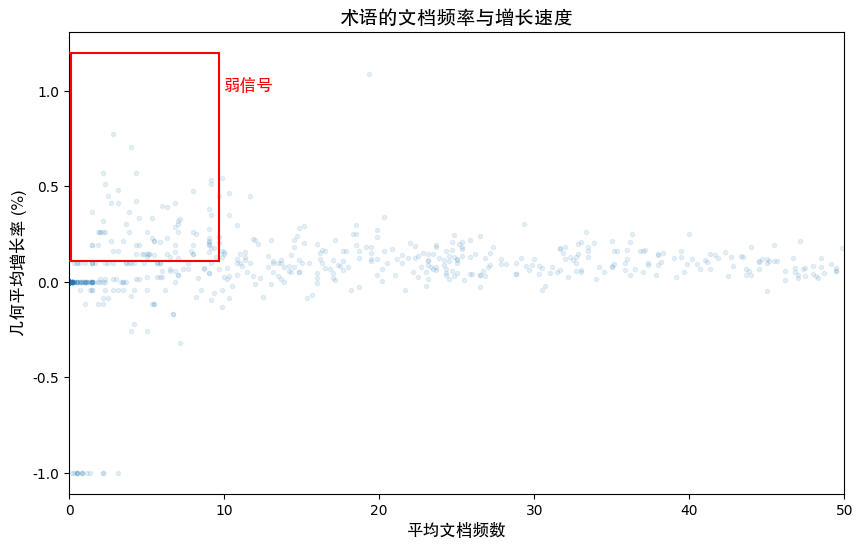

In [219]:
plt.figure(figsize=(10,6))
plt.scatter(dc.average, dod.rate, marker='.', alpha=0.1)
plt.plot([df_x, df_x], [df_y,1.2], color='r', zorder=3)
plt.plot([0,df_x],[df_y, df_y], color='r', zorder=3)
plt.plot([0,df_x],[1.2,1.2], color='r', zorder=3)
plt.plot([0.1,0.1],[df_y, 1.2], color='r', zorder=3)
plt.xlim([0,50])
#plt.ylim([-8,1])
plt.xlabel('平均文档频数', fontproperties=font_prop, fontsize=12)
plt.ylabel('几何平均增长率 (%)', fontproperties=font_prop, fontsize=12)
plt.title('术语的文档频率与增长速度', fontproperties=font_prop, fontsize=14)
plt.text(df_x+0.3,1, '弱信号', fontproperties=font_prop, fontsize=12, color='r')
plt.savefig('dod.jpg')
plt.show()

In [220]:
terms_oc = oc[oc.average <= of_x]['term']
terms_dc = dc[dc.average <= df_x]['term']
terms_dov = dov[dov.rate >= of_y]['term']
terms_dod = dod[dod.rate >= df_y]['term']

In [226]:
weak_signal = list((set(terms_oc) & set(terms_dc)) | (set(terms_dov) & set(terms_dod)))
len(weak_signal)

543

In [229]:
with open('weak_signal_dov_dod.txt','w',encoding='utf-8') as file:
    file.write(' '.join(weak_signal))

In [222]:
experiment = []
for n in [6,11,12,23,46,48,53]:
    with open(f'weak_signal/{n}_weak_signal.txt','r',encoding='utf-8') as file:
        ws = file.read().split('\n')
    for i in ws:
        experiment.append(i)
experiment = list(set(experiment))
len(experiment)

655

In [227]:
interaction = list(set(weak_signal) & set(experiment))
len(interaction)

288

In [230]:
with open('interaction.txt','w',encoding='utf-8') as file:
    file.write(' '.join(interaction))

In [228]:
print(f'{round((len(interaction)/len(weak_signal))*100,2)}%')

53.04%


In [211]:
experiment_filtered = []
for n in [6,11,12,23,46,48,53]:
    with open(f'weak_signal/{n}.txt','r',encoding='utf-8') as file:
        ws = file.read().split()
    for i in ws:
        experiment_filtered.append(i)
experiment_filtered = list(set(experiment_filtered))
len(experiment_filtered)

351

In [182]:
with open('weak_signal_dov_dod_filtered.txt','r',encoding='utf-8') as file:
    weak_signal_filtered = file.read().split()
len(weak_signal_filtered)

228

In [183]:
interaction_filtered = list(set(weak_signal_filtered) & set(experiment_filtered))
len(interaction_filtered)

61

In [184]:
print(f'{round((len(interaction_filtered)/len(weak_signal_filtered))*100,2)}%')

26.75%
